In [5]:
%%capture
! pip install openai
! pip install datasets
! pip install pyro-ppl
! pip install networkx

In [20]:
from openai import OpenAI
with open('key.txt', 'r') as file:
    key = file.read().replace('\n', '')

client = OpenAI(
    api_key=key
)

In [21]:
import openai

def openai_prompt(message_history, text_only=True):
    try:
        response = client.chat.completions.create(
            messages=message_history,
            model="gpt-4o-mini", # "gpt-3.5-turbo", # gpt-4o-mini
            temperature = 0.7,
            max_tokens=4095,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0

        )
        if text_only:
            return response.choices[0].message.content
        else:
            return response
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

## Expertise and prompt design
Iterated on prompt strategy.

TODO: better encapsulate repeated portions of this code, move prompts into a script hosted as text files to make code more readable.

### Summary of approach
TLDR: prompt the model iteratively, defining causal model as root nodes, root node relationships, then other relationships. After each prompt, update message history so that the LLM has all context:
1. use schema dictionary specifying data types and possible values for demographic variables
2. set up a message history with initial prompts explaining the task and schema for the llm
3. construct and send a prompt asking the LLM to identify root variables in a causal graph; extract root variables
5. send a prompt to the LLM to define relationships between root variables and other variables; extract relationships
6. prompt the LLM to define relationships between non-root variables; extract relationships
7. check for cycles in the relationships using networkx; if cycles exist, prompt the LLM to remove edges to form a valid DAG
8. display DAG visually (optional)
9. prompt the LLM to define structural equations for DAG nodes, considering schema-defined ranges or categories
10. prompt the LLM to convert the structural equations into a pyro model, with iterative error checking

Seems to work pretty well!

In [22]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# vis code for networkx dag
def plot_dag_layout(G):
    if not nx.is_directed_acyclic_graph(G):
        raise ValueError("graph is not a DAG")

    for layer, nodes in enumerate(nx.topological_generations(G)):
        for node in nodes:
            G.nodes[node]["layer"] = layer

    pos = nx.multipartite_layout(G, subset_key="layer")

    fig, ax = plt.subplots()
    nx.draw_networkx(G, pos=pos, ax=ax)
    ax.set_title("SCM generated by LLM (topological order)")
    fig.tight_layout()
    plt.show()

# extract the answer between <Answer>...</Answer> tags
def extract_answer(response_text):
    match = re.search(r"<Answer>(.*?)</Answer>", response_text, re.DOTALL)
    if match:
        return [item.strip() for item in match.group(1).split(",")]
    return []


### Schema seed and prompt
This is what a user inputs into the process: a valid schema dictionary (SDNIST style) alongside a very simple context prompt (something along the lines of "you are so and so expert"). The rest of the prompting is input agnostic.

In [23]:

schema = {
    "AGEP": {"dtype": "int64", "min": 0, "max": 95},
    "SEX": {"dtype": "int64", "values": [1, 2]},
    "MSP": {
        "has_null": True, "null_value": "N", "dtype": "object",
        "values": ["N", "1", "2", "3", "4", "5", "6"]
    },
    "HOUSING_TYPE": {"dtype": "int64", "values": [1, 2, 3]},
    "OWN_RENT": {"dtype": "int64", "values": [0, 1, 2]},
    "DENSITY": {"dtype": "float64", "min": 16, "max": 52864},
    "EDU": {
        "has_null": True, "null_value": "N", "dtype": "object",
        "values": ["N", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"]
    },
    "PINCP": {
        "has_null": True, "null_value": "N", "dtype": "object",
        "min": -9000, "max": 1327000
    },
}

census_prompt = [
    {
      "role": "system",
      "content": "You are an expert on demographic and census data."
    },
    {
      "role": "user",
      "content": "You are a helpful assistant to experts experts on demographic and census data. Our goal is to construct a causal graph between the following variables.\n"
    }
]


### Iterative prompting for SCM
Below works given the above schema and message prompt seed.

To identify the root nodes for the directed acyclic graph (DAG), we should look for variables that are likely to be independent and not influenced by any other variables in the schema provided. 

1. **AGEP**: Age is typically an independent variable and is not affected by other demographic factors in this context.
  
2. **SEX**: Gender is also generally considered an independent variable and is not influenced by other demographic characteristics.

3. **EDU**: Education level can be influenced by age and other socio-economic factors but is often considered a stable characteristic as well.

4. **HOUSING_TYPE**: The type of housing may depend on socio-economic status, which could be influenced by income but might also be considered somewhat independent.

5. **OWN_RENT**: Ownership status of a residence is often influenced by income, education, and age, and may not serve as a root variable.

6. **DENSITY**: Population density could be influenced by other social factors but might be conside

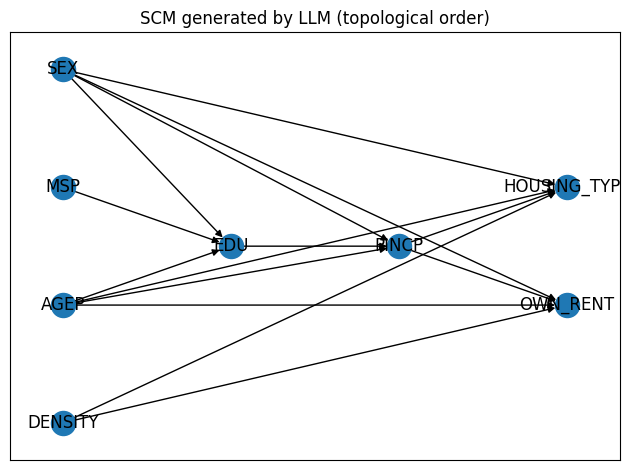


 Structural equations: To specify a set of structural equations, we will define the relationships according to the causal graph established earlier. Each equation will represent a probability distribution from which we can draw random values, ensuring that the values conform to the schema defined for each variable.

### Root Variables
1. **AGEP**: Age can be assumed to follow a uniform distribution within its range.
   - \( \text{AGEP} \sim \text{Uniform}(0, 95) \)

2. **SEX**: Gender can be modeled as a categorical distribution.
   - \( \text{SEX} \sim \text{Categorical}([0.5, 0.5]) \)  # Assuming equal probability for male (1) and female (2)

### Variables with Parent Nodes
3. **EDU**: Education may be influenced by age and sex. We can assume some conditional probabilities based on common trends (e.g., older individuals may have higher educational attainment).
   - \( \text{EDU} \sim \text{Categorical}(\text{P}_{EDU|AGEP, SEX}) \)  # P is a function derived from statistical data rel

In [24]:
import networkx as nx
import pyro
import pyro.distributions as dist
import re

# prompt block 1: block for independent variables
message_history = census_prompt.copy()
prompt_0 = f'Consider the following schema: {str(schema)}. \n'
prompt_1 = 'You are going to construct a causal graph, relying on your expertise, given only the above schema dictionary defining each variable name and domain/range/categories. When you are unfamiliar with a variable name, infer its identity from the context.\n'
prompt_2 = 'You will start by identifying which variable(s) should serve as the root nodes in a directed acyclic graph (DAG), which will represent a structural causal model between all variables (the best root variables are unaffected by any other variables).'
prompt_3 = 'Think step by step. Then, provide your final answer (variable names only, EXACTLY as they appear in the schema) within the tags <Answer>...</Answer>, seperated by ", ". '
prompt_0 += prompt_1
prompt_0 += prompt_2
prompt_0 += prompt_3

message_history.append({
                "role": "user",
                "content": prompt_0
            })

response_1 = openai_prompt(message_history)
root_variables = extract_answer(response_1)
root_variable_response = f'\n Root variables identified: {root_variables}\n\n'
print(response_1)
print(root_variable_response)

# add root_variable_response to history
message_history.append({
                "role": "assistant",
                "content": response_1
            })

message_history.append({
                "role": "assistant",
                "content": root_variable_response
            })

# run Prompt block 2
prompt_4 = 'Now, we are going to relate the root variables to other variables in our causal graph, relying on your expertise. Again, when you are unfamiliar with a variable name, infer its identity from the context.\n'
prompt_5 = 'You will now by identify relationships between root node variable(s) and remaining variables in the directed acyclic graph. Define a relationship between two variables as "X -> Y", using the "->" operator to denote a directed edge.\n'
prompt_6 = 'Think step by step. Then, provide your final answer (variable names only, with the "->" operator between each directed pair) within the tags <Answer>...</Answer>, seperated by ", ".'
prompt_4 += prompt_5
prompt_4 += prompt_6

message_history.append({
                "role": "user",
                "content": prompt_4
            })

response_2 = openai_prompt(message_history)
root_relationships = extract_answer(response_2)
root_relationships_response = f'\n Root relationships: {root_relationships}\n\n'
print(response_2)
print(root_relationships_response)

message_history.append({
                "role": "assistant",
                "content": response_2
            })

message_history.append({
                "role": "assistant",
                "content": root_relationships_response
            })

# run Prompt block 3
prompt_7 = 'Now, we are going to define any necessary relationships between variables that are NOT root variables in our causal graph, again relying on your expertise.\n'
prompt_8 = 'You will now by identify relationships between non-root variable(s). Remember, you can define a relationship between two variables as "X -> Y", using the "->" operator to denote a directed edge.\n'
prompt_9 = 'Think step by step. Remember, the graph is a DAG, so be careful not to introduce any cycles! Provide your final answer (variable names only, with the "->" operator between each directed pair) within the tags <Answer>...</Answer>, seperated by ", ".'
prompt_7 += prompt_8
prompt_7 += prompt_9

message_history.append({
                "role": "user",
                "content": prompt_7
            })

response_3 = openai_prompt(message_history)
non_root_relationships = extract_answer(response_3)
non_root_relationships_response = f'\n Non-root relationships: {non_root_relationships}\n\n'
print(response_3)
print(non_root_relationships_response)

message_history.append({
                "role": "assistant",
                "content": response_3
            })

message_history.append({
                "role": "assistant",
                "content": non_root_relationships_response
            })

relationships = root_relationships + non_root_relationships

def contains_cycles(relationships):
    G_temp = nx.DiGraph()
    for relationship in relationships:
        source, target = map(str.strip, relationship.split("->"))
        G_temp.add_edge(source, target)
    return not nx.is_directed_acyclic_graph(G_temp)

if contains_cycles(relationships):
    prompt_remove_cycles = f"The list of relationships you defined for our causal graph introduces cycles, making it invalid as a DAG: {str(relationships)} \n\n"
    prompt_remove_cycles += "Please remove the minimum number of edges to eliminate the cycles, while keeping the most important relationships according to your domain expertise. Make sure, however, that EVERY variable is still included."
    prompt_remove_cycles += "Return the final list of relationships without any cycles. Provide your final answer (relationships only, with the '->' operator between each directed pair) within the tags <Answer>...</Answer>, separated by ', '."
    message_history.append({
                "role": "user",
                "content": prompt_remove_cycles
            })
    response_remove_cycles = openai_prompt(message_history)
    relationships = extract_answer(response_remove_cycles)
    print(response_remove_cycles)
    print(relationships)
    message_history.append({
                "role": "assistant",
                "content": response_remove_cycles
            })

G = nx.DiGraph()
for relationship in relationships:
    source, target = map(str.strip, relationship.split("->"))
    G.add_edge(source, target)

assert nx.is_directed_acyclic_graph(G), "the graph is not a DAG - contains cycles"

print("DAG relationships:")
for edge in G.edges:
    print(f"{edge[0]} -> {edge[1]}")

plot_dag_layout(G)

schema_variables = set(schema.keys())
dag_variables = set(G.nodes)
missing_variables = schema_variables - dag_variables

assert len(missing_variables) == 0, f"The following variables are missing from the DAG: {missing_variables}"

prompt_10 = 'In the penultimate step, you are going to specify a set of structural equations, which are functions that relate each nodes value to the random variables of its parents.\n'
prompt_11 = 'For variables that are root nodes in the causal graph, parameterize a continuous or categorical distribution (depending on the variable type) using your domain expertise from which a random value can be drawn.\n'
prompt_12 = 'For variables that have parent nodes, parameterize a conditional distribution, which is a function of the values of the parents of that variable, using your domain expertise, from which a random value can be drawn.\n'
prompt_13 = 'Be careful to ensure that the values of the root variables and variables with parents stay within their schema defined range (in the case of continuous variables), or are valid codes (in the case of categorical variables).'
prompt_14 = 'Think step by step. Then, provide your final answer as a set of pyro like formulas ("X ~ ...", where you insert the formula) within the tags <Answer>...</Answer>, separated by newlines.'
prompt_10 += prompt_11
prompt_10 += prompt_12
prompt_10 += prompt_13
prompt_10 += prompt_14

message_history.append({
                "role": "user",
                "content": prompt_10
            })

response_4 = openai_prompt(message_history)
print(f'\n Structural equations: {response_4}\n\n')
print(response_4)

message_history.append({
                "role": "assistant",
                "content": response_4
            })

### Extracting valid code
Below takes the final answer, which is specified in various formats, and attempts to convert it into pyro code that can actually compile. It does this with iterative error checking, feeding error tracebacks into the next prompt message to make code fixes (default attempts k=5)

In [25]:
import torch
import pyro
import pyro.distributions as dist
import pyro.poutine
import traceback

def extract_pyro_code(response_text):
    match = re.search(r"<PyroCode>(.*?)</PyroCode>", response_text, re.DOTALL)
    if match:
        return match.group(1).strip()
    else:
        raise ValueError("No Pyro code found in the response text.")

def retrieve_pyro_model(pyro_code):
    local_dict = {}

    local_dict.update({
        'pyro': pyro,
        'dist': dist,
        'torch': torch
    })

    exec(pyro_code, globals(), local_dict)
    model = local_dict['model']
    pyro.clear_param_store()
    model_trace = pyro.poutine.trace(model).get_trace()

    return pyro_code

def robust_retrieve_pyro_model(pyro_code, prompt_fix_this_code, max_retries=5):
    attempt = 0
    while attempt < max_retries:
        try:
            # attempt to sample from the Pyro model
            pyro_code = retrieve_pyro_model(pyro_code)
            print(f'Succeeded, attempt {attempt}, final Pyro code:')
            print(pyro_code)
            return pyro_code
        except Exception as e:
            # grab the full stack trace
            error_traceback = traceback.format_exc()

            prompt_fix = prompt_fix_this_code(pyro_code, error_traceback)

            message_history.append({
                "role": "user",
                "content": prompt_fix
            })

            code_fix = openai_prompt(message_history)

            pyro_code = extract_pyro_code(code_fix)

            attempt += 1
            print(f"Attempt {attempt} failed with the following error: {e}")

    print("Max retries exceeded. The Pyro model could not be executed successfully.")
    print("Final Pyro code:")
    print(pyro_code)
    return None


In [26]:
prompt_generate_pyro_code = '''
Finally, you are going to convert the following Pyro-like formulas into executable Pyro code to create a structural causal model (SCM) that I can sample from.
The formulas specify how each variable is generated based on its parents in a directed acyclic graph (DAG).

Consider this example:
<Example>
X ~ Normal(0, 1)
Y ~ Normal(2 * X, 1)
</Example>

You should convert this into Pyro code like:
import pyro
import pyro.distributions as dist

def model():
    X = pyro.sample("X", dist.Normal(0, 1))
    Y = pyro.sample("Y", dist.Normal(2 * X, 1))
    return {"X": X, "Y": Y}

Be careful to include all functionality INSIDE of the model() function - no helpers! Now, please convert the following Pyro-like formulas into executable Pyro code:\n
'''
match = re.search(r"<Answer>(.*?)</Answer>", response_4, re.DOTALL)
prompt_generate_pyro_code += match.group(1)
prompt_generate_pyro_code += '\n\n'
prompt_generate_pyro_code += 'Be sure to properly handle any distributions and functional relationships between variables. ALWAYS return Pyro code within the tags <PyroCode>...</PyroCode>.'
message_history.append({
                "role": "user",
                "content": prompt_generate_pyro_code
            })

response_5 = openai_prompt(message_history)

The final code should compile!

In [27]:
pyro_code = extract_pyro_code(response_5)

In [28]:
final_pyro_code = robust_retrieve_pyro_model(pyro_code)

Attempt 1 failed with the following error: 'ellipsis' object has no attribute 'dim'
Succeeded, attempt 1, final Pyro code:
import torch
import pyro
import pyro.distributions as dist

def model():
    # Sample age from a uniform distribution
    AGEP = pyro.sample("AGEP", dist.Uniform(0, 95))
    
    # Sample sex from a categorical distribution
    SEX = pyro.sample("SEX", dist.Categorical(torch.tensor([0.5, 0.5])))
    
    # Sample education based on age and sex (mock probabilities)
    P_EDU = torch.tensor([0.1, 0.2, 0.2, 0.2, 0.1, 0.1])  # Example probabilities for different education levels
    EDU = pyro.sample("EDU", dist.Categorical(P_EDU))
    
    # Sample personal income based on education and age (mock mean and std)
    mu_PINCP = 20000 + 5000 * EDU.item() + 100 * AGEP  # Example mean function
    sigma_PINCP = 5000  # Fixed standard deviation
    PINCP = pyro.sample("PINCP", dist.Normal(mu_PINCP, sigma_PINCP))
    
    # Sample ownership status based on personal income and

### Finally, sampling with the code that compiles
The final code block can then be sampled from arbitrarily, producing a pandas dataframe.

In [29]:
def sample_from_trace(pyro_code, n=1000):
    samples = []
    local_dict = {}
    local_dict.update({
            'pyro': pyro,
            'dist': dist,
            'torch': torch
        })
    exec(pyro_code, globals(), local_dict)
    model = local_dict['model']
    pyro.clear_param_store()
    for _ in range(n):
        # pyro.clear_param_store()
        trace = pyro.poutine.trace(model).get_trace()
        sample = {name: trace.nodes[name]['value'].item() for name in trace.nodes if trace.nodes[name]['type'] == 'sample'}
        samples.append(sample)
    return pd.DataFrame(samples)

In [30]:
sample_from_trace(pyro_code)

AttributeError: 'ellipsis' object has no attribute 'dim'

### The final generated pyro code

In [4]:
print(pyro_code)

NameError: name 'pyro_code' is not defined